## Place Cell Analysis 
This notebook performs place cell detection and analysis using spatial information scores and ANOVA F-statistics. It includes:
- Computation of spatial tuning maps for individual neurons
- Statistical assessment using spatial information and ANOVA
- Permutation-based significance testing to identify place cells
- Visualization of spatial tuning across trials and positions


In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy import signal

from convnwb.io import make_session_name

from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot
from spiketools.plts.spatial import plot_heatmap, create_heatmap_title
from spiketools.plts.annotate import add_vlines, color_pvalue

from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates
from spiketools.utils.run import create_methods_list

In [2]:
import sys
sys.path.append('../code')
from models import create_df_place, fit_anova_place
from utils import  compute_firing_rates, compute_trial_firing_rates, compute_t_occupancy, circular_shuffle_unit_fr
sys.path.append('../scripts')
from settings import METHODS, SURROGATES

In [3]:

from scipy.io import loadmat
data = loadmat('/Users/weijiazhang/Data/Train/data_matfile/R1219C_0_train_events.mat')
behavioral_data = pd.read_csv('/Users/weijiazhang/Data/Train/events/events.csv')

In [4]:
def compute_trial_place_bins(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, epochSize):
    # Calculate spike counts per trial and position bin
    trial_spikes = np.zeros((len(edges_trial)-1, len(edges_pos)-1))
    for t, p, f in zip(trial_bin, pos_bin, units_fr):
        if t > 0 and t <= len(edges_trial)-1 and p > 0 and p <= len(edges_pos)-1:
            trial_spikes[t-1, p-1] += f * epochSize
    trial_fr = trial_spikes/trial_occupancy
    
    return  trial_fr

## Place Bin Settings 

In [5]:
bin_sets = [20,30,40,50,60]

## Settings 

In [6]:
numBins = bin_sets[1]
epochSize = 0.1
kernelSize = 2
numBinsSpeed = 25
units = 19

In [7]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

## Load Neural Data 

In [8]:
events_fr = data['events']['fr'][0][0]
events_fr.shape

(7654, 23)

## Load Behavioral Data 

In [9]:
# Get behavioral data
df = pd.DataFrame(data['events']['events'][0][0][0])
# Convert object columns to string type
str_cols = ['subj', 'object','timesfile']
for col in str_cols:
    df[col] = df[col].str[0].astype(str)
# Convert numeric columns to appropriate types
int_cols = ['session', 'trialNum', 'blockType', 'driveType'] 
float_cols = ['object_position', 'response_position', 'response_mstime', 'timesoffset','mstime', 'position','speed']
for col in int_cols:
    df[col] = df[col].str[0].astype(int)
for col in float_cols:
    df[col] = df[col].str[0].astype(float)

behavioral_data = df

## Spike Name

In [10]:
spike_name = data['events']['spikeData'][0][0]['spikeNames'][0][0][0][units]
print(f"Spike name: {spike_name}")


Spike name: ['NSX124_2']


## Speed

In [11]:
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2

In [12]:
# behavioral_data = behavioral_data[~bad]
# events_fr = events_fr[~bad,:]

## Unit Data

In [13]:
units_fr = events_fr[:,units]

In [14]:
type(events_fr)

numpy.ndarray

## Extract Position Data

In [15]:
positions = behavioral_data['position']
positions = (positions + 34) / 68  # Normalize to 0-1 range
positions[positions < 0] = 0  # Clip values below 0
positions[positions > 1] = 1 
positions 

0       0.000439
1       0.002422
2       0.006106
3       0.011512
4       0.018584
          ...   
7649    0.930124
7650    0.942914
7651    0.954228
7652    0.964259
7653    0.973158
Name: position, Length: 7654, dtype: float64

In [27]:
PLACE_METHODS = {'PLACE':['ANOVA','INFO']}

 
The number of bins is 20.00
The Spatial Information is 0.08
The ANOVA place F-value is 4.85


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_51464/709868282.py:7: RuntimeWarning: invalid value encountered in divide
  trial_fr = trial_spikes/trial_occupancy


 
The number of bins is 30.00
The Spatial Information is 0.09
The ANOVA place F-value is 3.07
 
The number of bins is 40.00
The Spatial Information is 0.11
The ANOVA place F-value is 3.12
 
The number of bins is 50.00
The Spatial Information is 0.12
The ANOVA place F-value is 2.50
 
The number of bins is 60.00
The Spatial Information is 0.13
The ANOVA place F-value is 2.18


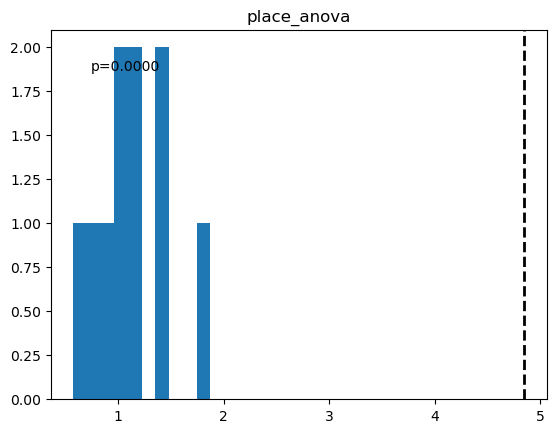

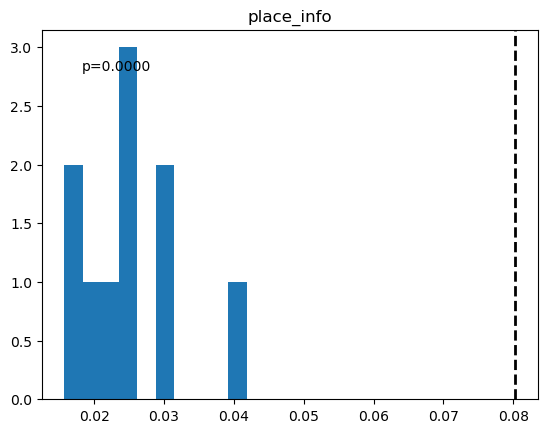

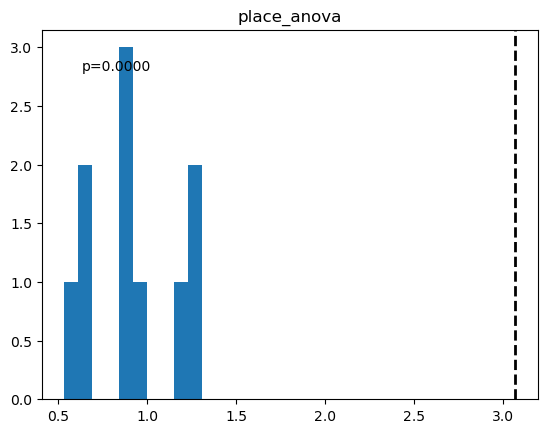

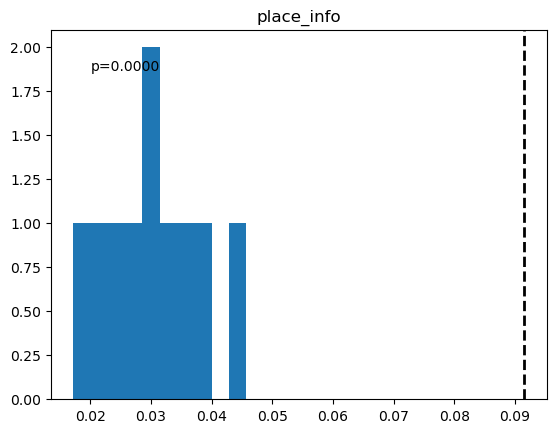

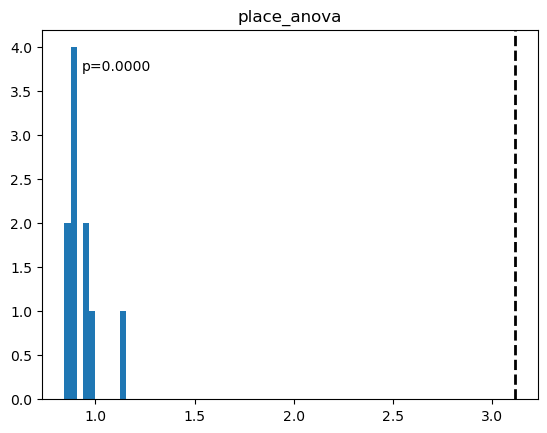

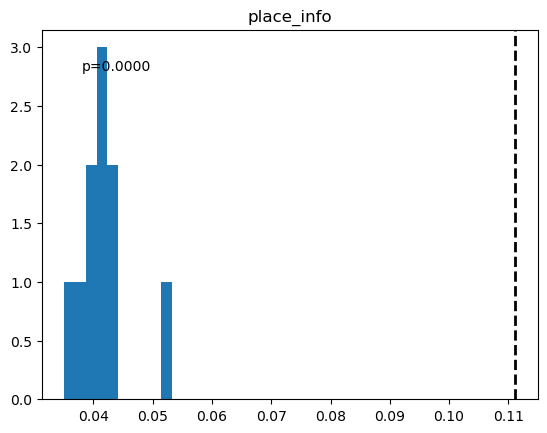

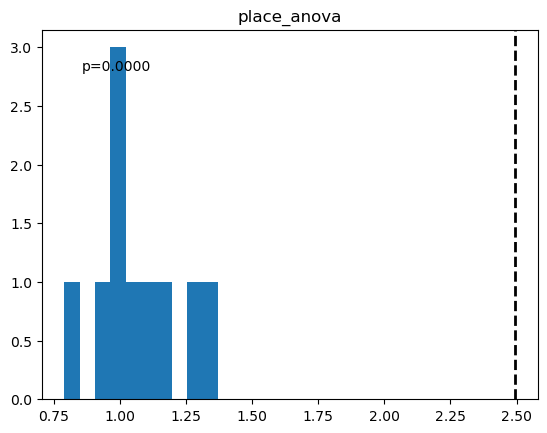

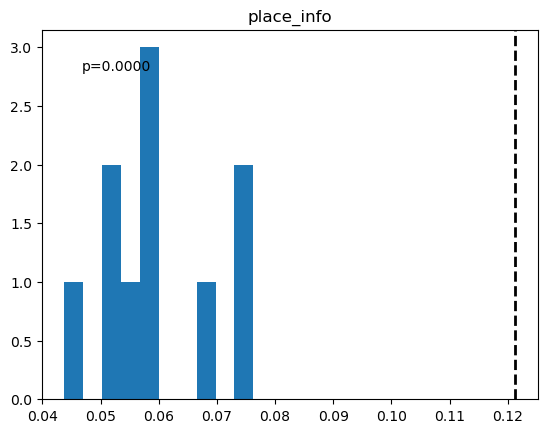

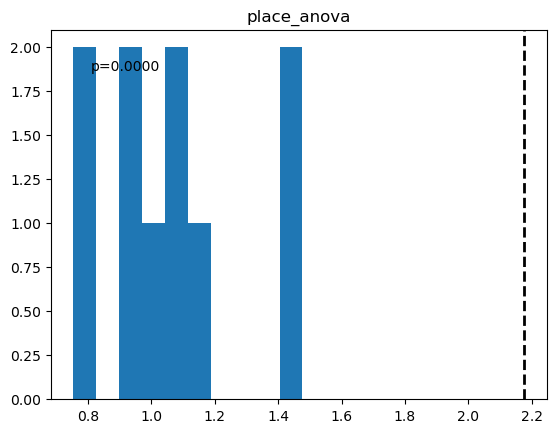

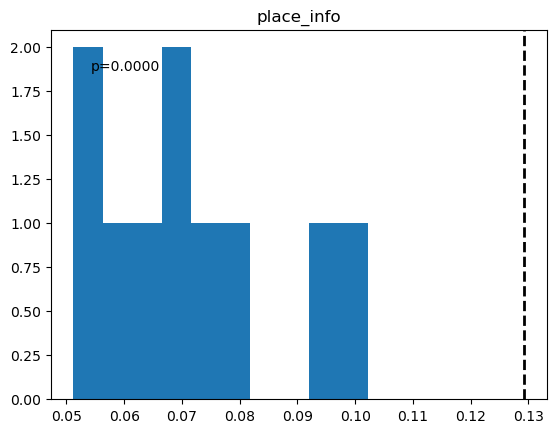

In [32]:
for i in range(len(bin_sets)):
    numBins = bin_sets[i]
    edges_pos = np.linspace(0, 100, numBins+1)
    pos_bin = np.digitize(positions*100, edges_pos)
    count, _ = np.histogram(positions*100, bins=edges_pos)
    print(' ')
    print('The number of bins is {:4.2f}'.format(numBins))

    ## Compute Occupancy
    occ = count * epochSize

    ## Compute Trial Occupancy
    edges_trial = np.arange(0.5, 65, 1)  # 0.5:1:65 in MATLAB
    trial_bin = np.array(behavioral_data['trialNum'])
    trial_occupancy = compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize)

    ## Compute Trial Place Bins
    trial_place_bins = compute_trial_place_bins(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy,epochSize)
    place_bins = np.nanmean(trial_place_bins,axis = 0)
    ## Statistical Analysis 
    results = {}
    # Compute mutual information of spiking and location
    results['place_info'] = compute_spatial_information(place_bins, occ, normalize=False)
    print('The Spatial Information is {:4.2f}'.format(results['place_info']))
    ## ANOVA
    df = create_df_place(trial_place_bins[:,:-3])
    results['place_anova']= fit_anova_place(df)
    # Check the computed place F-value
    print('The ANOVA place F-value is {:4.2f}'.format(results['place_anova']))

    shuffles = circular_shuffle_unit_fr(units_fr, SURROGATES['n_shuffles'])

    surr_analyses = create_methods_list(PLACE_METHODS)
    surrs = {analysis : \
                    np.zeros(SURROGATES['n_shuffles']) for analysis in surr_analyses}
    for ind, shuffle in enumerate(shuffles):
        surr_trial_place_bins = compute_trial_place_bins(trial_bin, pos_bin, shuffle, edges_trial, edges_pos, trial_occupancy, epochSize)
        surr_place_bins = np.nanmean(surr_trial_place_bins,axis = 0)
       
        #surr_place_bins= np.nanmean(surr_trial_place_bins,axis = 0)
        surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)
        surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_trial_place_bins))
    for analysis in surr_analyses:
        results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
                        compute_surrogate_stats(results[analysis], surrs[analysis],title = analysis,plot = True)
        
